<a href="https://colab.research.google.com/github/Ethanshibu/AEGIS-dotfiles/blob/main/ImageGen_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from tqdm.notebook import tqdm


In [3]:
device = "cuda"
batch_size = 128    # For training loop
noise_dim = 64      # For the Generator

# Optimization Parameters
lr = 0.0002
beta1 = 0.5
beta2 = 0.99

# Training Variables
epochs = 20

In [4]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [5]:
from torchvision import datasets, transforms as T

In [6]:
train_augs = T.Compose([
    T.RandomRotation((-20,+20)),
    T.ToTensor()      # (h,w,c) => (c,h,w)
])

In [7]:
trainset = datasets.MNIST('MNIST/',download=True,train=True,transform=train_augs)
# It has 60,000 training images

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.0MB/s]


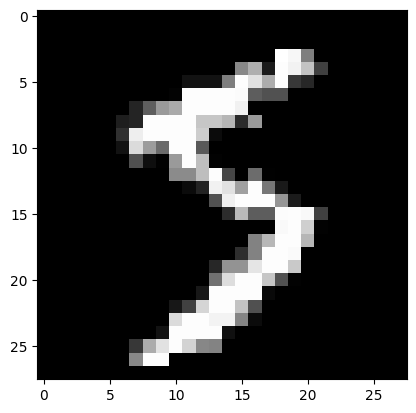

In [8]:
image, label = trainset[0]
plt.imshow(image.squeeze(),cmap='gray')

In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
print("Total number of batches in trainloader: ", len(trainloader))

Total number of batches in trainloader:  469


In [11]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [12]:
def show_tensor_images(tensor_img,num_images = 16,size = (1,28,28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images],nrow=4)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.show()

  #   This function will be used to plot images of the batch

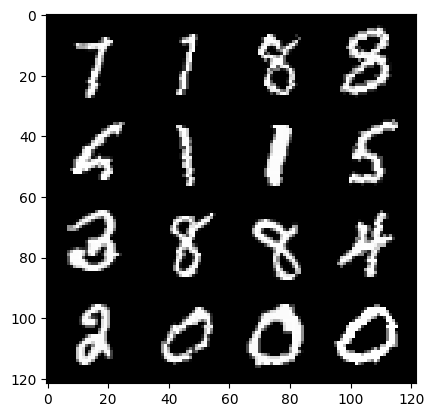

In [13]:
show_tensor_images(images,num_images=16)

In [14]:
def get_disc_block(in_channels,out_channels,kernel_size,stride):
  return torch.nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [21]:
from torchsummary import summary

In [25]:
class Discriminator(nn.Module):

  def __init__(self) -> None:
     super(Discriminator, self).__init__()

     self.block1 = get_disc_block(1,16,(3,3),2)
     self.block2 = get_disc_block(16,32,(5,5),2)
     self.block3 = get_disc_block(32,64,(5,5),2)

     self.flatten = nn.Flatten()
     self.linear = nn.Linear(in_features=64,out_features=1)


  def forward(self,images):
    x1 = self.block1(images)
    x2 = self.block2(x1)
    x3 = self.block3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [27]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [28]:
def get_gen_block(in_channels,out_channels,kernel_size,stride,final_block = False):
  if final_block == True:
    return torch.nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()
    )
  return torch.nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )



In [32]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.block1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block2 = get_gen_block(256,128,(4,4),1)
    self.block3 = get_gen_block(128,64,(3,3),2)

    self.block4 = get_gen_block(64,1,(4,4),2,final_block=True)

  def forward(self,random_noise_vector):
    x = random_noise_vector.view(-1,noise_dim,1,1)
    x1 = self.block1(x)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.block4(x3)
    return x4

In [33]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(noise_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [35]:
def weights_init(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    nn.init.normal_(m.weight,0.0,0.02)
  if isinstance(m,nn.BatchNorm2d):
    nn.init.normal_(m.weight,0.0,0.02)
    nn.init.constant_(m.bias,0)

In [36]:
D = D.apply(weights_init)
G = G.apply(weights_init)

In [39]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

In [37]:
D_opt = torch.optim.Adam(D.parameters(),lr = lr,betas=(beta1,beta2))
G_opt = torch.optim.Adam(G.parameters(),lr = lr,betas=(beta1,beta2))

training loop


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/20 - D Loss: 0.6851 - G Loss: 0.7010


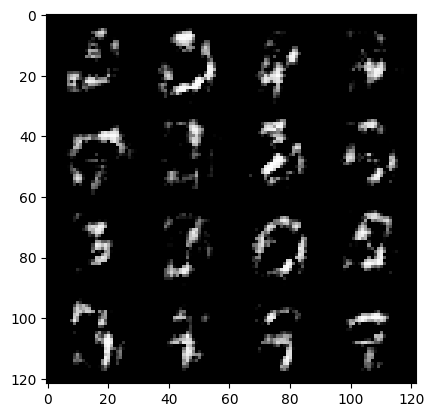

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/20 - D Loss: 0.6773 - G Loss: 0.7125


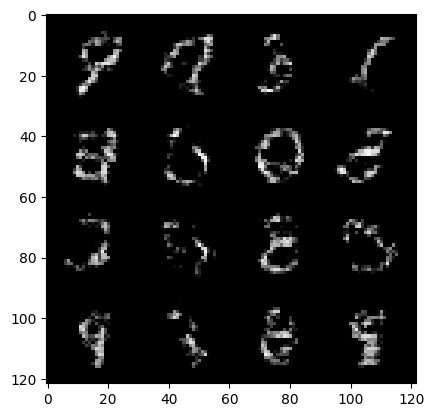

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/20 - D Loss: 0.6370 - G Loss: 0.7601


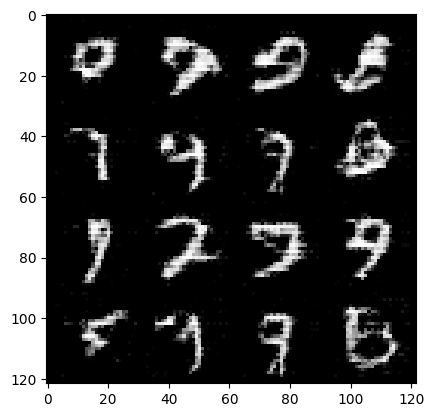

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/20 - D Loss: 0.6055 - G Loss: 0.8051


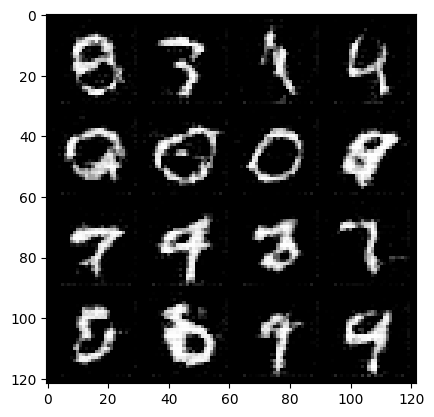

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/20 - D Loss: 0.5896 - G Loss: 0.8391


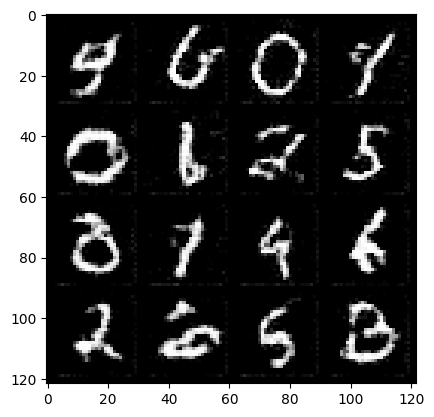

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/20 - D Loss: 0.5889 - G Loss: 0.8537


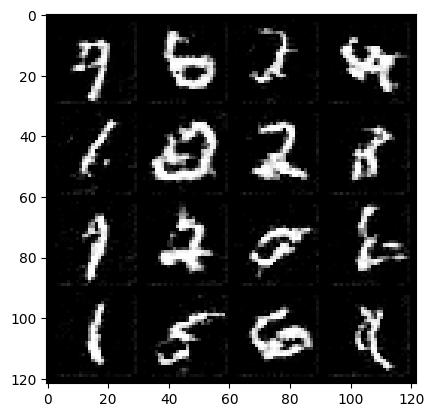

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/20 - D Loss: 0.5988 - G Loss: 0.8509


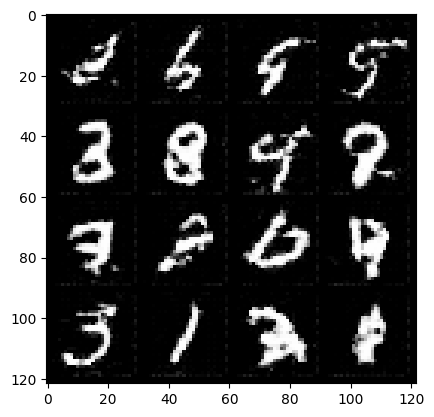

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/20 - D Loss: 0.6123 - G Loss: 0.8418


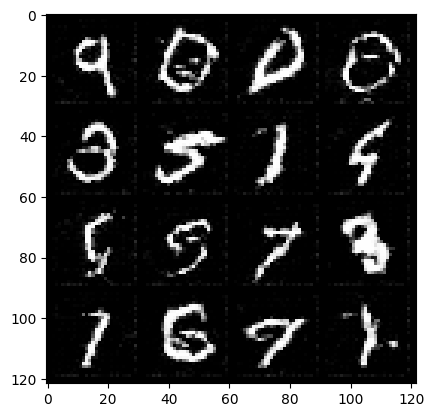

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/20 - D Loss: 0.6229 - G Loss: 0.8333


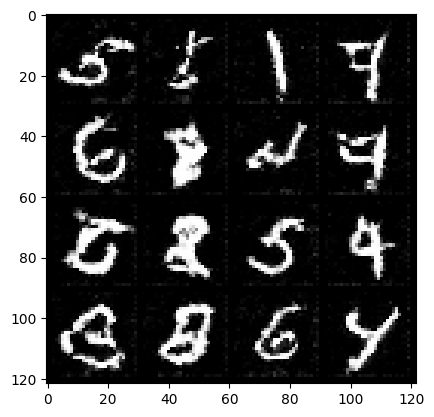

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/20 - D Loss: 0.6291 - G Loss: 0.8288


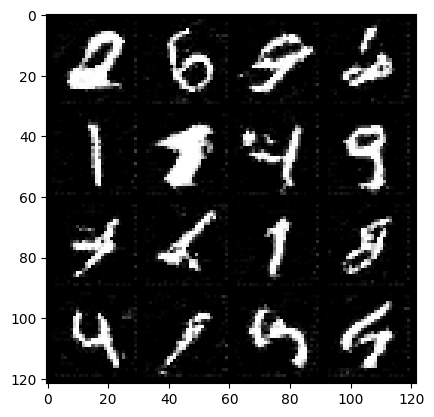

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/20 - D Loss: 0.6334 - G Loss: 0.8214


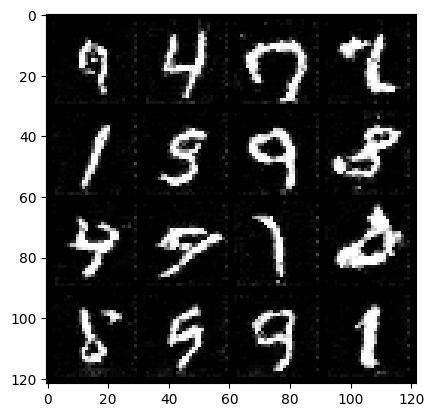

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/20 - D Loss: 0.6358 - G Loss: 0.8179


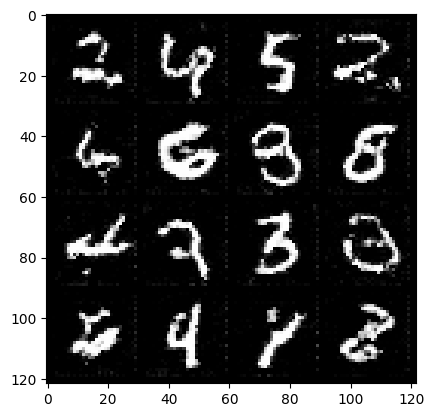

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/20 - D Loss: 0.6376 - G Loss: 0.8163


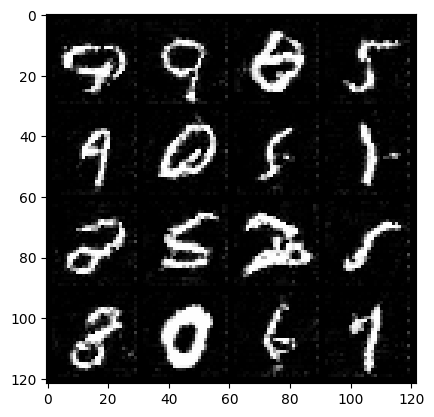

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/20 - D Loss: 0.6399 - G Loss: 0.8156


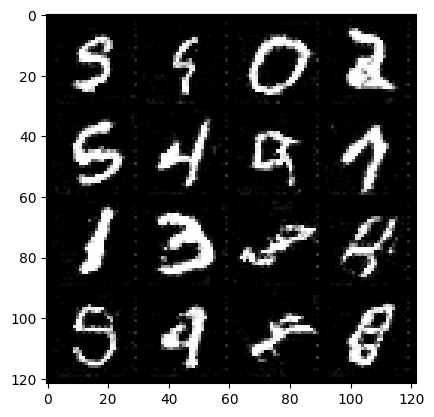

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/20 - D Loss: 0.6407 - G Loss: 0.8145


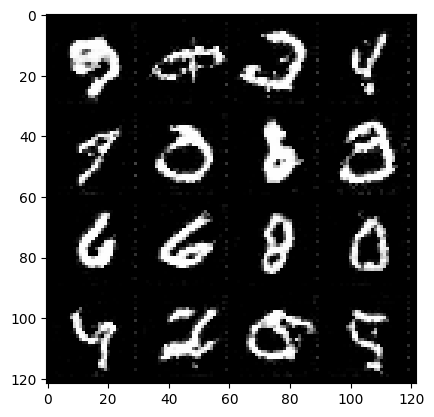

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/20 - D Loss: 0.6428 - G Loss: 0.8137


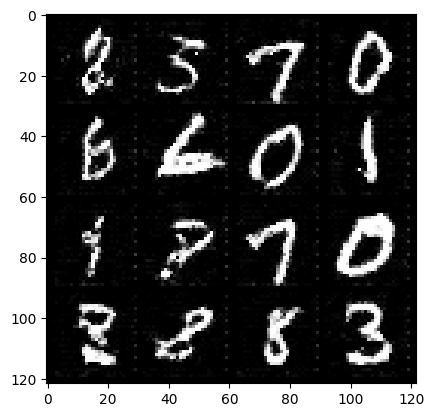

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/20 - D Loss: 0.6437 - G Loss: 0.8122


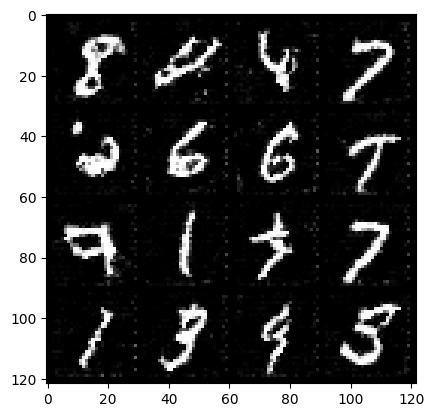

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/20 - D Loss: 0.6441 - G Loss: 0.8105


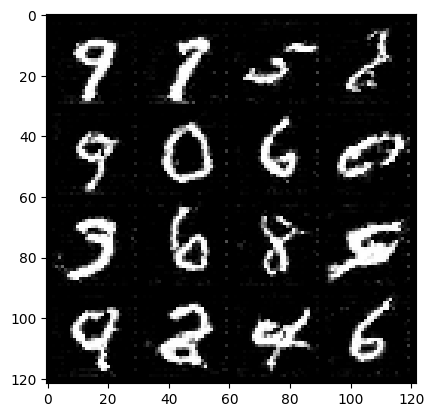

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/20 - D Loss: 0.6448 - G Loss: 0.8101


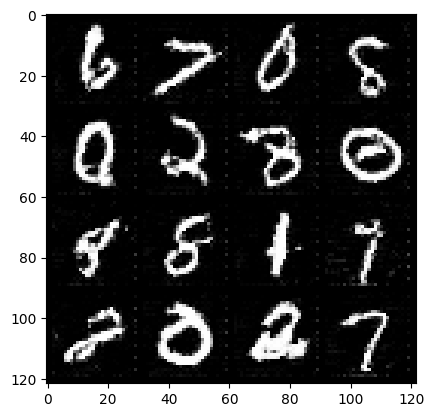

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/20 - D Loss: 0.6450 - G Loss: 0.8105


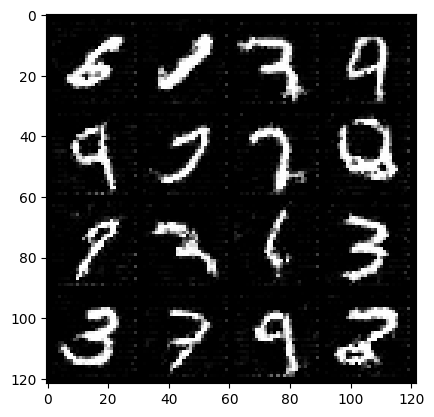

In [40]:
for epoch in range(epochs):
    total_d_loss = 0
    total_g_loss = 0

    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(device)
        batch_size = real_img.size(0)
        noise = torch.randn(batch_size, noise_dim, device=device)

        ### 1. Train Discriminator ###
        D_opt.zero_grad()

        # Generate fake images
        fake_img = G(noise).detach()  # detach to avoid gradient flow to G

        # Compute Discriminator loss on real and fake
        D_pred_real = D(real_img)
        D_pred_fake = D(fake_img)

        D_loss_real = real_loss(D_pred_real)
        D_loss_fake = fake_loss(D_pred_fake)

        D_loss = (D_loss_real + D_loss_fake) / 2
        D_loss.backward()
        D_opt.step()

        ### 2. Train Generator ###
        G_opt.zero_grad()

        # Generate fake images (again)
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_img = G(noise)

        # Discriminator tries to classify fake as real
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)

        G_loss.backward()
        G_opt.step()

        # Accumulate for logging
        total_d_loss += D_loss.item()
        total_g_loss += G_loss.item()


        avg_d_loss = total_d_loss / len(trainloader)
        avg_g_loss = total_g_loss / len(trainloader)

    print(f"Epoch {epoch + 1}/{epochs} - D Loss: {avg_d_loss:.4f} - G Loss: {avg_g_loss:.4f}")

    show_tensor_images(fake_img)